<a href="https://colab.research.google.com/github/kursatkara/MAE_5020_Spring_2025/blob/master/05_03_Nonlinear_pendulum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Nonlinear Pendulum**

The code in this notebook is based on [1].

[1] This notebook was made by Prof. Volodymir Vovchenko as a part of his course Computational Physics course (PHYS 6350), available on GitHub as https://github.com/vlvovch/PHYS6350-ComputationalPhysics

https://github.com/kursatkara/PHYS6350-ComputationalPhysics/blob/main/code/7_OrdinaryDifferentialEquations/7b_ClassicalMechanics.ipynb


## Lagrangian mechanics

In Lagrangian mechanics, a classical system with $N$ degrees of freedom is characterized by generalized coordinates $\{q_j\}$ that obey Euler-Lagrange equations of motion:
$$
\frac{d}{dt} \left( \frac{\partial L}{\partial \dot{q}_j}\right ) - \frac{\partial L}{\partial q_j} = 0, \qquad j = 1\ldots N
$$

$L$ is the non-relativistic Lagrangian which is typically defined as the difference of kinetic and potential energies, $L = T - V$.
One can rewrite these equations using chain rules:
$$
\sum_{i=1}^N \frac{\partial^2 L}{\partial \dot{q}_j \, \partial \dot{q}_i} \ddot{q}_i = - \sum_{i=1}^N \frac{\partial^2 L}{\partial \dot{q}_j \, \partial q_i} \dot{q}_i -\frac{\partial^2 L}{\partial \dot{q}_j \, \partial t} + \frac{\partial L}{\partial q_j}, \qquad j = 1\ldots N.
$$
The term $-\frac{\partial^2 L}{\partial \dot{q}_j \, \partial t}$ in the r.h.s. corresponds to the scenario where we have explicit time dependence of the Lagrangian.

This is a system of $N$ linear equations which determines $\ddot{q}_i$ as function of $\{q_j\}$ and $\{\dot{q}_j \}$, i.e.
$$
\ddot{q}_i = f_i(\{q_j\},\{\dot{q}_j\},t).
$$
This system of 2nd-order ODE can be straightforwardly rewritten into $2N$ system of first-order ODEs
\begin{align*}
\frac{d q_i}{dt} & = \dot{q}_i, \\
\frac{d \dot{q}_i}{dt} & = f_i(\{q_j\},\{\dot{q}_j\},t),
\end{align*}
and solved using standard methods.

## Non-linear pendulum

![pendulum](https://raw.githubusercontent.com/kursatkara/MAE_5020_S24/master/Data/pendulum.gif)

The generalized coordinate of the non-linear pendulum is the displacement angle $\theta$.
One has
$$
x = l \sin(\theta), \qquad y = -l \cos(\theta),
$$
thus the Lagrangian of a non-linear pendulum is
$$
L = T - V = \frac{m l^2 \dot{\theta}^2}{2} - m g l \cos(\theta),
$$
and the Lagrange equations of motion read
$$
 \ddot{\theta} + \frac{g}{l} \sin \theta = 0.
$$

In [1]:
import numpy as np

import matplotlib.pyplot as plt
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'xtick.direction':'in',
         'ytick.direction':'in',
         }
plt.rcParams.update(params)

################################################################################
def ode_rk4_step(f, x, t, h):
    """Perform a single step h using 4th order Runge-Kutta method.

    Args:
    f: the function that defines the ODE.
    x: the value of the dependent variable at the present step.
    t: the present value of the time variable.
    h: the time step

    Returns:
    xnew: the value of the dependent variable at the step t+h
    """
    k1 = h * f(x,t)
    k2 = h * f(x + k1/2., t + h /2.)
    k3 = h * f(x + k2/2., t + h /2.)
    k4 = h * f(x + k3, t + h)
    return x + (k1 + 2. * k2 + 2. * k3 + k4) / 6.

################################################################################
# The default definition of the error (distance) between two state vectors
# Default: the magnitude of the difference vector
def distance_definition_default(x1, x2):
    diff = x1 - x2
    diffnorm = np.sqrt(np.dot(diff, diff))
    return diffnorm

################################################################################
def ode_rk4_adaptive_multi(f, x0, t0, h0, tmax, delta = 1.e-6, distance_definition = distance_definition_default):
    """Solve an ODE dx/dt = f(x,t) from t = t0 to t = t0 + h*steps
    using 4th order Runge-Kutta method with adaptive time step.

    Args:
          f: the function that defines the ODE.
         x0: the initial value of the dependent variable.
         t0: the initial value of the time variable.
         h0: the initial time step
       tmax: the maximum time
      delta: the desired accuracy per unit time

    Returns:
    t,x: the pair of arrays corresponding to the time and dependent variables
    """

    ts = [t0]
    xs = [x0]

    h = h0
    t = t0
    i = 0

    while (t < tmax):
        if (t + h >= tmax):
            ts.append(tmax)
            h = tmax - t
            xs.append(ode_rk4_step(f, xs[i], ts[i], h))
            t = tmax
            break

        x1 = ode_rk4_step(f, xs[i], ts[i], h)
        x1 = ode_rk4_step(f, x1, ts[i] + h, h)
        x2 = ode_rk4_step(f, xs[i], ts[i], 2*h)

        diffnorm = distance_definition(x1, x2)
        if diffnorm == 0.: # To avoid the division by zero
            rho = 2.**4
        else:
            rho = 30. * h * delta / diffnorm
        if rho < 1.:
            h *= rho**(1/4.)
        else:
            if (t + 2.*h) < tmax:
                xs.append(x1)
                ts.append(t + 2*h)
                t += 2*h
            else:
                xs.append(ode_rk4_step(f, xs[i], ts[i], h))
                ts.append(t + h)
                t += h
            i += 1
            h = min(2.*h, h * rho**(1/4.))

    return ts,xs

In [2]:
################################################################################
# Parameters:
g  = 9.81 # m/s^2
l = 0.1  # m
m = 1.0  # kg

################################################################################
def fpendulum(xin, t):
    theta = xin[0]
    omega = xin[1] # theta1 dot
    domega = - g / l * np.sin(theta) # theta double dot or omega dot

    return np.array([omega,
                     domega
                    ])

################################################################################
def error_definition_pendulum(x1, x2):
    return np.abs(x1[0] - x2[0])

################################################################################
def kinetic_energy(xin):
    theta = xin[0]
    omega = xin[1]
    return 0.5 * m * l**2 * omega**2

################################################################################
def potential_energy(xin):
    theta = xin[0]
    omega = xin[1]
    return -m * g * l * np.cos(theta)

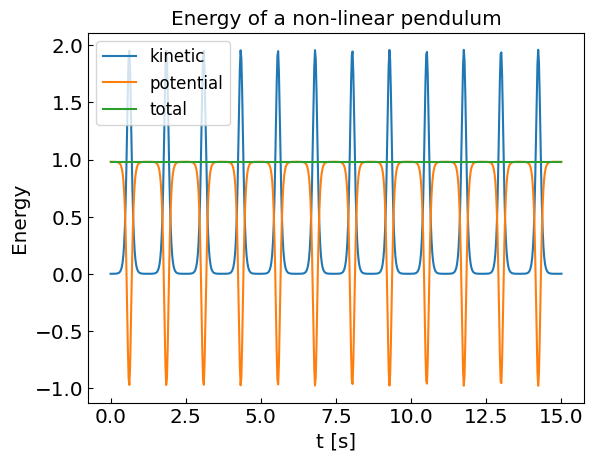

In [3]:
################################################################################
theta_0 = 179. * np.pi / 180.
omega_0 = 0.
x0 = np.array([theta_0, omega_0])

t0 = 0.
tend = 15. # s
cx = x0
eps = 1.e-8

################################################################################
def calcpos(x):
    return np.array([l*np.sin(x[0]), -l*np.cos(x[0])])

################################################################################
ts = [t0]
qs = [x0]
energies_case1 = [[kinetic_energy(x0)], [potential_energy(x0)], [kinetic_energy(x0) + potential_energy(x0)]]

fps = 40
dt = 1./fps
for ct in np.arange(t0, tend, dt):
    sol = ode_rk4_adaptive_multi(fpendulum, cx, ct, 0.5 * dt, ct+dt, eps, error_definition_pendulum)
    cx = sol[1][-1]

    T = kinetic_energy(cx)
    V = potential_energy(cx)
    ts.append(ct + dt)
    qs.append(cx)

    energies_case1[0].append(T)
    energies_case1[1].append(V)
    energies_case1[2].append(T+V)

################################################################################
# Plot the energies
plt.plot(ts, energies_case1[0], label = 'kinetic')
plt.plot(ts, energies_case1[1], label = 'potential')
plt.plot(ts, energies_case1[2], label = 'total')
plt.xlabel('t [s]')
plt.ylabel('Energy')
plt.title("Energy of a non-linear pendulum")
plt.legend()
plt.show()

In [4]:
################################################################################
# Visualize
def nonlinear_pendulum_plot(cx,ct, axis, labelini = "${\\theta^0 = 179}$", mode = 0):
    axis.set_xlabel("x [cm]")
    axis.set_ylabel("y [cm]")
    if mode == 1:
        axis.set_ylabel("")
        axis.get_yaxis().set_ticklabels([])

    axis.set_xlim(-1.1*(l)*1.e2,1.1*(l)*1.e2)
    axis.set_ylim(-1.1*(l)*1.e2,1.1*(l)*1.e2)
    axis.axhline(y = 0., color = 'black', linestyle = '--')
    # plt.axis('equal')
    axis.set_aspect(1)

    axis.text(-0.3*(l)*1.e2, 0.6*(l)*1.e2, labelini, fontsize=12)

    pos = calcpos(cx) * 1.e2

    axis.plot([pos[0]],[pos[1]], 'o', color = 'red',label='mass')
    axis.plot([0.,pos[0]],[0,pos[1]], color = 'red',label='rod')

    # labelrec = "Non-linear pendulum, t = " + "{:.2f}".format(ct) + " s"
    labelrec = "t = " + "{:.2f}".format(ct) + " s"
    axis.set_title(labelrec)


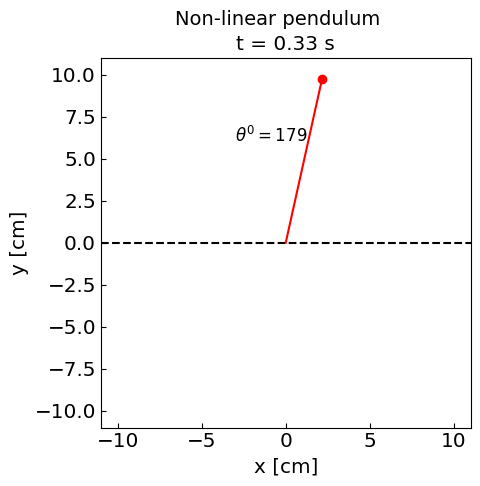

In [5]:
################################################################################
kk = 13
fig, ax = plt.subplots()
ax.clear()
nonlinear_pendulum_plot(qs[kk], ts[kk], ax)
fig.suptitle("Non-linear pendulum", fontsize = 14)
plt.show()

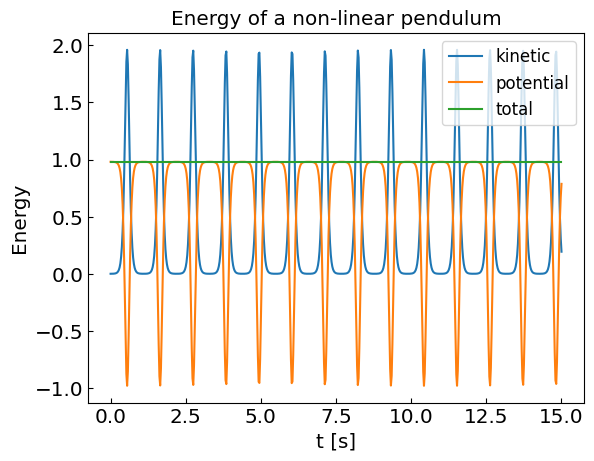

In [6]:
################################################################################
theta_0 = 178 * np.pi / 180.
omega_0 = 0.
x0 = np.array([theta_0, omega_0])

t0 = 0.
tend = 15. # s
cx = x0
eps = 1.e-8

################################################################################
def calcpos(x):
    return np.array([l*np.sin(x[0]), -l*np.cos(x[0])])

################################################################################
ts2 = [t0]
qs2 = [x0]
energies_case2 = [[kinetic_energy(x0)], [potential_energy(x0)], [kinetic_energy(x0) + potential_energy(x0)]]

fps = 40
dt = 1./fps
for ct in np.arange(t0, tend, dt):
    sol = ode_rk4_adaptive_multi(fpendulum, cx, ct, 0.5 * dt, ct+dt, eps, error_definition_pendulum)
    cx = sol[1][-1]

    T = kinetic_energy(cx)
    V = potential_energy(cx)
    ts2.append(ct + dt)
    qs2.append(cx)

    energies_case2[0].append(T)
    energies_case2[1].append(V)
    energies_case2[2].append(T+V)

################################################################################
# Plot the energies
plt.plot(ts, energies_case2[0], label = 'kinetic')
plt.plot(ts, energies_case2[1], label = 'potential')
plt.plot(ts, energies_case2[2], label = 'total')
plt.xlabel('t [s]')
plt.ylabel('Energy')
plt.title("Energy of a non-linear pendulum")
plt.legend()
plt.show()

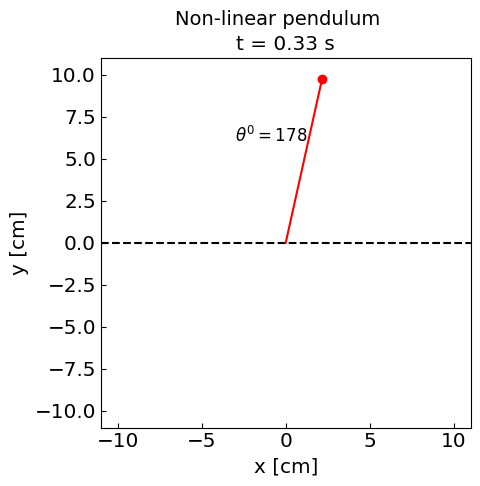

In [7]:
################################################################################
kk = 13
fig, ax = plt.subplots()
ax.clear()
nonlinear_pendulum_plot(qs[kk], ts[kk], ax, "${\\theta^0 = 178}$")
fig.suptitle("Non-linear pendulum", fontsize = 14)
plt.show()


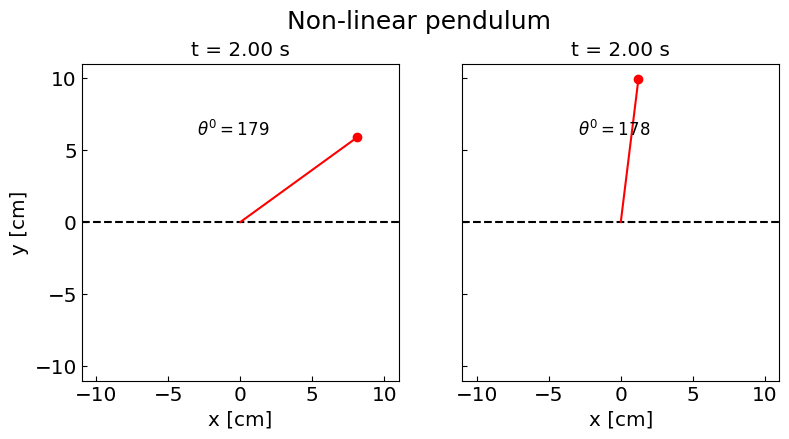

In [8]:
################################################################################
fig, ax = plt.subplots(1, 2)
kk = 80
nonlinear_pendulum_plot(qs[kk], ts[kk], ax[0])
nonlinear_pendulum_plot(qs2[kk], ts2[kk], ax[1], "${\\theta^0 = 178}$", 1)
fig.set_size_inches(9, 5, forward=True)
fig.suptitle("Non-linear pendulum", fontsize = 18)
plt.subplots_adjust(top=1.)
plt.show()

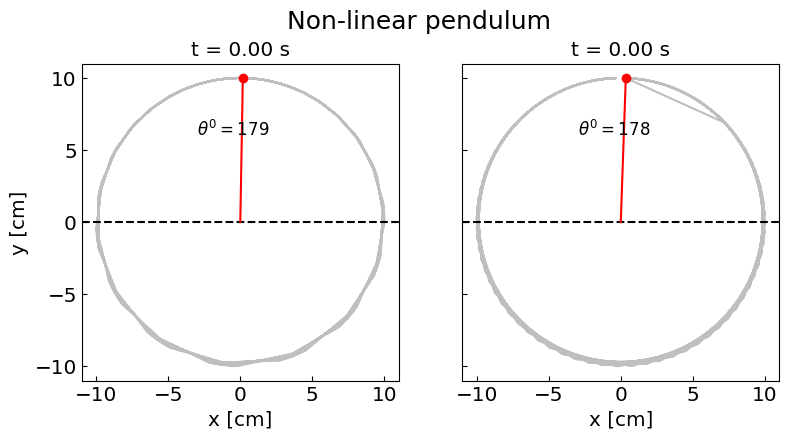

In [9]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(9, 5, forward=True)
fig.suptitle("Non-linear pendulum", fontsize=18)
plt.subplots_adjust(top=1.)

# Initialize lists to store the traces
trace_x1, trace_y1 = [], []
trace_x2, trace_y2 = [], []

def animate_pendulum(i):
    ax[0].clear()
    ax[1].clear()

    # Update the traces
    pos1 = calcpos(qs[i]) * 1.e2
    pos2 = calcpos(qs2[i]) * 1.e2
    trace_x1.append(pos1[0])
    trace_y1.append(pos1[1])
    trace_x2.append(pos2[0])
    trace_y2.append(pos2[1])

    # Plot the traces
    ax[0].plot(trace_x1, trace_y1, '-', color='gray', alpha=0.5)
    ax[1].plot(trace_x2, trace_y2, '-', color='gray', alpha=0.5)

    # Plot the pendulums
    nonlinear_pendulum_plot(qs[i], ts[i], ax[0])
    nonlinear_pendulum_plot(qs2[i], ts2[i], ax[1], "${\\theta^0 = 178}$", 1)

ani = FuncAnimation(fig, animate_pendulum, frames=fps * round(tend), interval=1000/fps, repeat=False)
# plt.show()


ani.save("nonlinear_pendulum_compare_trace.gif")

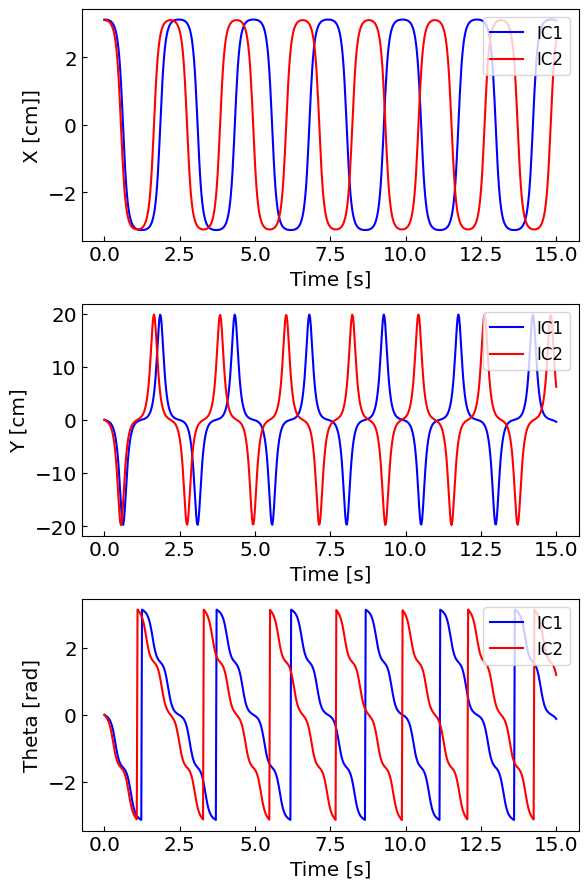

In [10]:
################################################################################
# Plotting x, y, theta versus time.

# Extracting x and y values
x1 = [item[0] for item in qs]
y1 = [item[1] for item in qs]

x2 = [item[0] for item in qs2]
y2 = [item[1] for item in qs2]

# Calculating theta using atan2
theta1 = np.arctan2(y1, x1)
theta2 = np.arctan2(y2, x2)

#theta1_unwrapped = np.unwrap(theta1)
#theta2_unwrapped = np.unwrap(theta2)

# Creating subplots
fig, axs = plt.subplots(3, 1, figsize=(6, 9))

# Plot x vs t
axs[0].plot(ts, x1, 'b', label='IC1')
axs[0].plot(ts2, x2, 'r', label='IC2')
#axs[0].set_title('X vs Time')
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel('X [cm]]')
axs[0].legend(loc='upper right')

# Plot y vs t
axs[1].plot(ts, y1, 'b', label='IC1')
axs[1].plot(ts2, y2, 'r', label='IC2')
#axs[1].set_title('Y vs Time')
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('Y [cm]')
axs[1].legend(loc='upper right')

# Plot theta vs t
axs[2].plot(ts, theta1, 'b', label='IC1')
axs[2].plot(ts2, theta2, 'r', label='IC2')
#axs[2].set_title('Theta vs Time')
axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('Theta [rad]')
axs[2].legend(loc='upper right')

# Adjusting layout
plt.tight_layout()

# Display the plots
plt.show()